# Time-Series MIA Example 

In [ ]:
import os, sys, yaml, numpy as np, matplotlib.pyplot as plt, torch, random

project_root = os.path.abspath(os.path.join(os.getcwd(), "../../.."))
sys.path.append(project_root)

from examples.mia.time_series_mia.utils.data_preparation import preprocess_ECG_dataset, preprocess_EEG_dataset, get_dataloaders
from examples.mia.time_series_mia.utils.model_preparation import create_trained_model_and_metadata
from examples.mia.time_series_mia.utils.models.LSTM import LSTM
from examples.mia.time_series_mia.utils.models.TCN import TCN
from examples.mia.time_series_mia.utils.models.DLinear import DLinear
from examples.mia.time_series_mia.utils.models.TimesNet import TimesNet
from examples.mia.time_series_mia.utils.models.NBeats import NBeats
from examples.mia.time_series_mia.utils.models.TFT import TFT
from examples.mia.time_series_mia.utils.models.WaveNet import WaveNet

/home/zyzz/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
audit_config_path = "audit.yaml"
train_config_path = "train_config.yaml"

# Load the yaml files
with open(audit_config_path, 'r') as file:
    audit_config = yaml.safe_load(file)

with open(train_config_path, 'r') as file:
    train_config = yaml.safe_load(file)

In [ ]:
random_seed = train_config["run"]["random_seed"]
log_dir = train_config["run"]["log_dir"]

epochs = train_config["train"]["epochs"]
batch_size = train_config["train"]["batch_size"]
optimizer = train_config["train"]["optimizer"] # Fix so we use this

lookback = train_config["data"]["lookback"]
horizon = train_config["data"]["horizon"]
num_individuals = train_config["data"]["num_individuals"]
train_fraction = train_config["data"]["f_train"]
test_fraction = train_config["data"]["f_test"]
dataset = train_config["data"]["dataset"]
data_dir = train_config["data"]["data_dir"]
stride = train_config["data"]["stride"]
k_lead = train_config["data"]["k_lead"] # number of leading variables to use (applicable for EEG only)

In [ ]:
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [ ]:
# Get data loaders
path = os.path.join(os.getcwd(), data_dir)
target_data_file = audit_config["target"]["data_path"].split('/')[-1]

if dataset == 'ECG' and target_data_file == 'ECG.pkl':
    dataset = preprocess_ECG_dataset(path, lookback, horizon, num_individuals, k_lead=k_lead, stride=stride)
elif dataset == 'EEG' and target_data_file == 'EEG.pkl':
    dataset = preprocess_EEG_dataset(path, lookback, horizon, num_individuals, k_lead=k_lead, stride=stride)
else:
    raise Exception(f"Received unknown dataset or mismatching target file: dataset={dataset}, target={target_data_file}.")

train_loader, test_loader = get_dataloaders(dataset, train_fraction, test_fraction, batch_size=batch_size)

In [5]:
# Train the model
input_dim = dataset.x.shape[-1]   # input size will be the amount of variables in the Time-Series
model_name = audit_config["target"]["model_class"]

if model_name == "LSTM":
    model = LSTM(input_dim, horizon)
elif model_name == "TCN":
    model = TCN(input_dim, horizon)
elif model_name == "DLinear":
    model = DLinear(input_dim, lookback, horizon)
elif model_name == "TimesNet":
    model = TimesNet(input_dim, lookback, horizon)
elif model_name == "NBeats":
    model = NBeats(input_dim, lookback, horizon)
elif model_name == "TFT":
    model = TFT(input_dim, lookback, horizon)
elif model_name == "WaveNet":
    model = WaveNet(input_dim, horizon)
else:
    raise NotImplementedError()

train_loss, test_loss = create_trained_model_and_metadata(model, train_loader, test_loader, epochs)

Training Progress: 100%|██████████| 10/10 [02:27<00:00, 14.73s/it]


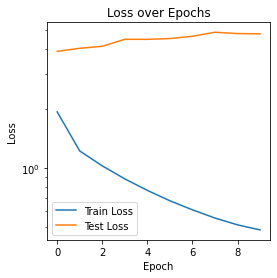

In [6]:
# Plot training and test loss
plt.figure(figsize=(4, 4))
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

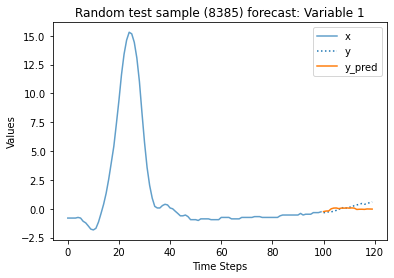

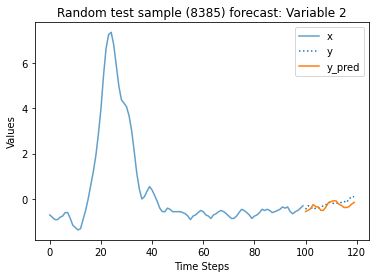

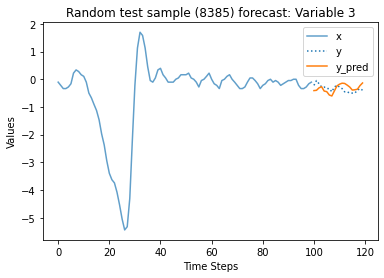

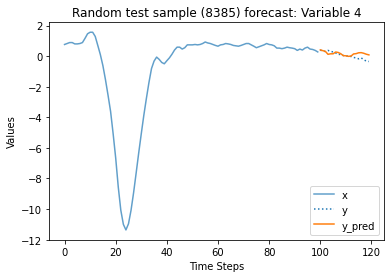

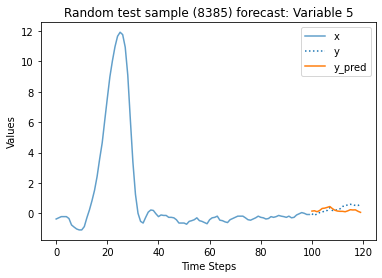

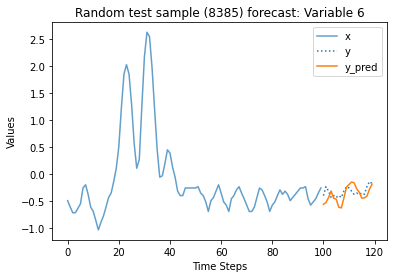

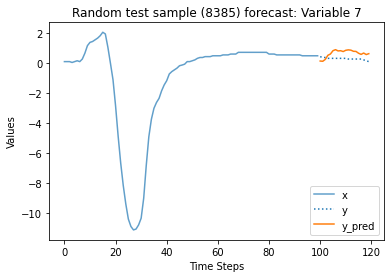

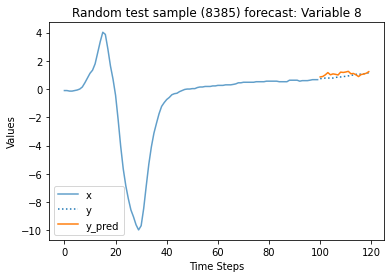

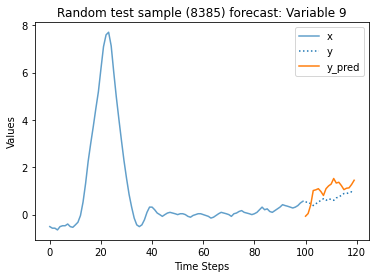

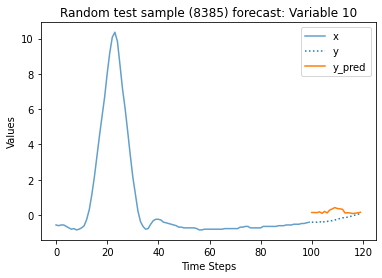

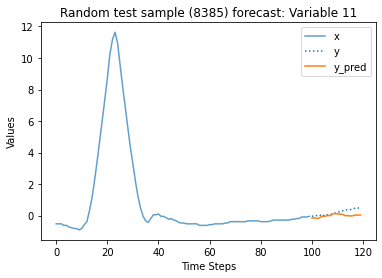

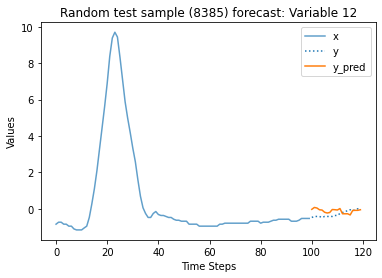

In [81]:
indices = test_loader.dataset.indices
random_sample_idx = np.random.choice(indices)
x = dataset.x[random_sample_idx,:,:]
y = dataset.y[random_sample_idx,:,:]
y_pred = model(x.unsqueeze(0)).detach().squeeze(0)

# Time axis
time_x = np.arange(lookback)
time_y = np.arange(lookback, lookback + horizon)

for i in range(y.shape[-1]):  # plot forecast for each variable in the series
    plt.plot(time_x, x[:, i], label='x', alpha=0.7)  # lookback
    plt.plot(time_y, y[:, i], label='y', color='C0', linestyle='dotted')  # true horizon
    plt.plot(time_y, y_pred[:, i], label='y_pred', color='C1')  # prediction

    plt.xlabel("Time Steps")
    plt.ylabel("Values")
    plt.legend()
    plt.title(f"Random test sample ({random_sample_idx}) forecast: Variable {i+1}")
    plt.show()

In [7]:
from data_handler import IndividualizedInputHandler
from leakpro import LeakPro

# Prepare leakpro object
leakpro = LeakPro(IndividualizedInputHandler, audit_config_path)

# Run the audit 
leakpro.run_audit()

2025-02-28 17:29:11,844 INFO     Target model blueprint created from WaveNet in ./utils/models/WaveNet.py.
2025-02-28 17:29:11,856 INFO     Loaded target model metadata from ./target/model_metadata.pkl
2025-02-28 17:29:11,872 INFO     Loaded target model from ./target


{'audit': {'random_seed': 42, 'attack_list': {'ensemble': {'training_data_fraction': 0.5, 'attack_data_fraction': 0.5, 'num_instances': 50, 'subset_size': 50, 'num_pairs': 5, 'audit': True}}, 'output_dir': './leakpro_output', 'attack_type': 'mia', 'modality': 'time_series'}, 'target': {'module_path': './utils/models/WaveNet.py', 'model_class': 'WaveNet', 'target_folder': './target', 'data_path': './data/ECG.pkl'}, 'shadow_model': None, 'distillation_model': None}


KeyboardInterrupt: 

### Testing signals

In [ ]:
print(f'Mean train MSE:', np.mean(train_loss))
print(f'Mean test MSE:', np.mean(test_loss))

Avg train MSE: 0.0010738943250353451
Avg test MSE: 0.0008281765227577994


In [ ]:
from torch.nn import MSELoss
from leakpro.signals.signal import SeasonalityLoss, TrendLoss
from leakpro.signals.signal_extractor import PytorchModel

pmodel = PytorchModel(model, MSELoss)

seasonality_signal = SeasonalityLoss()
train_sloss = seasonality_signal([pmodel], leakpro.handler, train_loader.dataset.indices)
test_sloss = seasonality_signal([pmodel], leakpro.handler, test_loader.dataset.indices)

trend_signal = TrendLoss()
train_tloss = trend_signal([pmodel], leakpro.handler, train_loader.dataset.indices)
test_tloss = trend_signal([pmodel], leakpro.handler, test_loader.dataset.indices)

print(f'Mean train seasonality loss:', np.mean(train_sloss))
print(f'Mean test seasonality loss:', np.mean(test_sloss))

print(f'Mean train trend loss:', np.mean(train_tloss))
print(f'Mean test trend loss:', np.mean(test_tloss))

Getting trend loss for model 1/ 1: 100%|██████████| 4576/4576 [00:11<00:00, 415.47it/s]

Mean train seasonality loss: 3.8450737130659878
Mean test seasonality loss: 3.8556961747737493
Mean train trend loss: 0.6672897970401903
Mean test trend loss: 0.6773139758794336
